# Test of the constant variance values using only feedforward layers

This notebook presents some tests of a feedforward neural network using the Constant Variance weight initialisation with a comparison to Xavier initialisation.

Before running this notebook, run the `ActivationCoefficients.ipynb` notebook to generate the constant variance coefficients.

In [1]:
import numpy as np

from PIL import Image, ImageDraw, ImageFont
import torch
from torch import nn

import torchvision
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize

import matplotlib.pyplot as plt

torch.manual_seed(10)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# This is tested on two datasets, the first is a basic dataset, the cancer dataset, the second it the Fashion MNIST dataset.
fashion_mnist_data = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST/',
    download=True,
    transform=Compose([
        ToTensor(),
        Lambda(lambda x: Normalize(torch.mean(x), torch.std(x), inplace=False)(x))
    ]))

# The dataset applied through the training transform
train_transform = Compose([
    torchvision.transforms.RandomHorizontalFlip(),
])

# The dataset applied through the validation transform
validation_transform = Compose([
])

# Split the dataset into train and validation
# There are 70_000 samples total, so choose a 60_000/10_000 split
fashionMNIST_dataset_train, fashionMNIST_dataset_validation = torch.utils.data.random_split(fashion_mnist_data, [55000, 5000])

# Create dataloaders
fashionMNIST_dataset_loader_train = torch.utils.data.DataLoader(fashionMNIST_dataset_train, batch_size=128, shuffle=True)
fashionMNIST_dataset_loader_validation = torch.utils.data.DataLoader(fashionMNIST_dataset_validation, batch_size=128, shuffle=False)

# Verify the data is normalised
print("Sample mean: " + str(torch.mean(fashion_mnist_data[1][0]).item()))
print("Sample std: " + str(torch.std(fashion_mnist_data[1][0]).item()))

Sample mean: 9.731370376186987e-09
Sample std: 0.9999999403953552


C:\Users\rmenzies\AppData\Local\Temp\ipykernel_12064\249862655.py:10: DeprecationWarning: BOX is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BOX instead.
  img_to_draw = img[0].convert("RGBA").resize((img[0].width*4, img[0].height*4), Image.BOX) #scale(4) 125


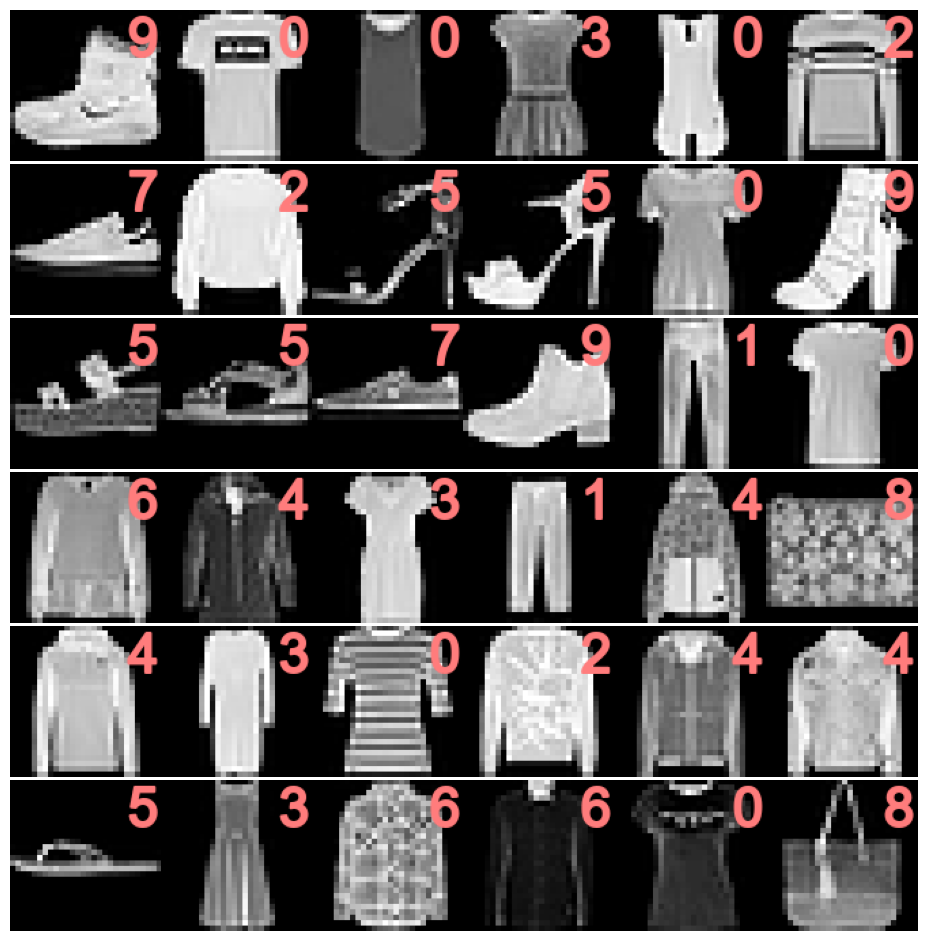

In [3]:
# Display some images from the FashionMNIST dataset, used in training the neural networks
fashion_mnist_data_display = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST/', download=False)

grid_size = 6

fig, axes = plt.subplots(grid_size, grid_size, figsize=(11.7, 12), gridspec_kw={"wspace":0, "hspace":0})

for (a, img) in zip(axes.flatten(), fashion_mnist_data_display):
    fnt = ImageFont.truetype("C:\Windows\Fonts\Arial.ttf", 40)
    img_to_draw = img[0].convert("RGBA").resize((img[0].width*4, img[0].height*4), Image.BOX) #scale(4) 125
    draw = ImageDraw.Draw(img_to_draw)
    draw.text((img_to_draw.size[0]-25, -2), str(img[1]), fill=(255, 70, 70, 180), font=fnt, stroke_width=1)
    a.imshow(img_to_draw, cmap="gray")
    a.set_axis_off()

fig.savefig("./FashionMNISTDatasetImg6.png")

del fashion_mnist_data_display

In [3]:
def get_accuracy(model, dataloader, device, transform):
    """ Determine the top-1 accuracy of the model using the data in the `dataloader` """
    model.eval()
    with torch.no_grad():
        acc_total = 0
        acc_len = 0
        for X,y in dataloader:
            acc_total += (torch.argmax(model(transform(X).to(device)), dim=1) == y.to(device)).int().sum()
            acc_len += len(y)
        final_acc = acc_total/acc_len
    model.train()
    return final_acc.item()


def training_loop(neural_net, optimizer, loss_fn, loss_arr=[], validation_acc_arr = [], collected_weights_std_arr=[], collected_weights_mean_arr=[]):
    """
    Run a training loop over all the data in the FashionMNIST dataset.
    This runs for a single epoch, put this in a loop to run multiple epochs.
    """
    for batch, (X, y) in enumerate(fashionMNIST_dataset_loader_train):
        pred = neural_net(X.to(device))
        loss = loss_fn(pred, y.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 50 == 0:
            if batch % 200 == 0:
                print('\r', 'Loss:', str(loss.item()), end='                                ')

            valid_acc = get_accuracy(neural_net, fashionMNIST_dataset_loader_validation, "cuda", validation_transform)
            validation_acc_arr.append(valid_acc)

            loss_arr.append(loss.item())

            # Get the distribution of the weights, like in Xavier et Al.
            j = 0
            for p in neural_net.modules():
                if p.__class__.__name__ == "Linear":
                    collected_weights_std_arr[j].append(torch.std(p.weight).item())
                    collected_weights_mean_arr[j].append(torch.mean(p.weight).item())
                    j+=1


In [4]:
class NeuralNetworkActivationTest(nn.Module):
    """ A neural network which performs input normalisation through the initial weights """
    def __init__(self, activation):
        super(NeuralNetworkActivationTest, self).__init__()
        self.flatten = nn.Flatten()
        activation = activation()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 100),
            activation,
            nn.Linear(100, 58),
            activation,
            nn.Linear(58, 38),
            activation,
            nn.Linear(38, 28),
            activation,
            nn.Linear(28, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits#

def test_activation_function_xavier(activation_function, learning_rate = 0.01, epochs = 15):
    """ Run a test for a specific activation function """
    print("Using activation function: " + str(activation_function))

    model = NeuralNetworkActivationTest(activation_function).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #Adam

    # Initialise the weights using Xavier initialisation
    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                nn.init.xavier_uniform_(p.weight)

    loss_values = []
    validation_accuracy_arr = []
    collected_weights_mean = []
    collected_weights_std = []

    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            collected_weights_mean.append([])
            collected_weights_std.append([])

    for i in range(epochs):
        print()
        print('Iteration', i)
        training_loop(
            model,
            optimizer,
            loss_fn,
            loss_values,
            validation_accuracy_arr,
            collected_weights_std,
            collected_weights_mean)
    return model, optimizer, loss_values, validation_accuracy_arr, collected_weights_mean, collected_weights_std


def test_activation_function_he(activation_function, learning_rate = 0.01, epochs = 30):
    """ Run a test for a specific activation function """
    print("Using activation function: " + str(activation_function))

    model = NeuralNetworkActivationTest(activation_function).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #Adam

    # Initialise the weights using Xavier initialisation
    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                nn.init.kaiming_normal_(p.weight)
                p.bias.zero_()

    loss_values = []
    validation_accuracy_arr = []
    collected_weights_mean = []
    collected_weights_std = []

    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            collected_weights_mean.append([])
            collected_weights_std.append([])

    for i in range(epochs):
        print()
        print('Iteration', i)
        training_loop(
            model,
            optimizer,
            loss_fn,
            loss_values,
            validation_accuracy_arr,
            collected_weights_std,
            collected_weights_mean)
    return model, optimizer, loss_values, validation_accuracy_arr, collected_weights_mean, collected_weights_std

coeff_const_var_normal = {
    nn.Sigmoid: 1.8465,
    nn.Tanh: 1.5925,
    nn.ReLU: 1.4139,
    nn.Softsign: 2.3376,
    nn.ELU: 1.2453,
    nn.SiLU: 1.6766,
    nn.GELU: 1.5331,
    nn.SELU: 1.0000,
    nn.Mish: 1.4867,
}

coeff_const_var_uniform = {
    nn.Sigmoid: 3.1980,
    nn.Tanh: 2.7584,
    nn.ReLU: 2.4489,
    nn.Softsign: 4.0489,
    nn.ELU: 2.1569
}

def test_activation_function_const_var(activation_function, learning_rate = 0.01, epochs = 30, normal=True):
    model = NeuralNetworkActivationTest(activation_function).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    if normal:
        normalising_coefficient = coeff_const_var_normal[activation_function]
    else:
        normalising_coefficient = coeff_const_var_uniform[activation_function]

    # Initialise the weights
    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            with torch.no_grad():
                if normal:
                    p.weight.normal_(0, normalising_coefficient/np.sqrt(p.weight.shape[1]))
                else:
                    bound = normalising_coefficient/np.sqrt(p.weight.shape[1])
                    p.weight.uniform_(-bound, bound)
                p.bias.zero_()

    loss_values = []
    validation_accuracy_arr = []
    collected_weights_mean = []
    collected_weights_std = []

    for p in model.modules():
        if p.__class__.__name__ == "Linear":
            collected_weights_mean.append([])
            collected_weights_std.append([])

    for i in range(epochs):
        print()
        print('Iteration', i)
        training_loop(
            model,
            optimizer,
            loss_fn,
            loss_values,
            validation_accuracy_arr,
            collected_weights_std,
            collected_weights_mean)
    return model, optimizer, loss_values, validation_accuracy_arr, collected_weights_mean, collected_weights_std


In [8]:
# All the activation functions to test
activation_functions_list = [
    nn.ReLU,
    nn.SiLU,
    nn.GELU,
    nn.Mish,
    nn.SELU,
    nn.ELU,
]

activation_functions_list_name = [
    "relu",
    "silu",
    "gelu",
    "mish",
    "selu",
    "elu",
]

In [9]:

def write_json_test_results(f, results_arr):
    f.write("{")
    for i in range(len(activation_functions_list_name)):
        f.write("\"" + activation_functions_list_name[i] + "\":" + "[" + ",".join([str(a) for a in results_arr[i]]) + "]")
        if i < len(activation_functions_list_name)-1:
            f.write(",")

    f.write("}\n")

In [12]:
for i in range(0, 5):
    activation_function_tests_losses = []
    activation_function_validation_accuracies = []

    activation_function_tests_means = []
    activation_function_tests_stds = []

    # Test each activation function using xavier initialisation
    for a in activation_functions_list:
        print()
        print("Using activation: " + str(a))
        _, _, losses, validations, means, stds = test_activation_function_he(a, epochs=30)
        activation_function_tests_losses.append(losses)
        activation_function_validation_accuracies.append(validations)
        activation_function_tests_means.append(means)
        activation_function_tests_stds.append(stds)


    prefix = "./HeConstVarFashionMNIST_test/" + str(i) + "/"

    with open(prefix + "he_tests_losses.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_losses)
    with open(prefix + "he_tests_validation_acc.json", "w+") as f:
        write_json_test_results(f, activation_function_validation_accuracies)
    with open( prefix + "he_tests_means.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_means)
    with open(prefix + "he_tests_stds.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_stds)


Using activation: <class 'torch.nn.modules.activation.ReLU'>
Using activation function: <class 'torch.nn.modules.activation.ReLU'>

Iteration 0
 Loss: 0.4506780207157135                                
Iteration 1
 Loss: 0.4785242974758148                                 
Iteration 2
 Loss: 0.3757777810096741                                
Iteration 3
 Loss: 0.3843398094177246                                 
Iteration 4
 Loss: 0.3237316906452179                                 
Iteration 5
 Loss: 0.2698485255241394                                 
Iteration 6
 Loss: 0.4147016406059265                                
Iteration 7
 Loss: 0.38147053122520447                                
Iteration 8
 Loss: 0.3354809582233429                                
Iteration 9
 Loss: 0.35289570689201355                                
Iteration 10
 Loss: 0.3169306516647339                                
Iteration 11
 Loss: 0.2754226624965668                                 
Iteration 12
 Loss

In [13]:
for i in range(0, 5):
    activation_function_tests_losses_const_var = []
    activation_function_validation_accuracies_const_var = []

    activation_function_tests_means_const_var = []
    activation_function_tests_stds_const_var = []

    # Test each activation function using constant variance initialisation
    for a in activation_functions_list:
        print()
        print("Using activation: " + str(a))
        _, _, losses, validations, means, stds = test_activation_function_const_var(a, epochs=30)
        activation_function_tests_losses_const_var.append(losses)
        activation_function_validation_accuracies_const_var.append(validations)
        activation_function_tests_means_const_var.append(means)
        activation_function_tests_stds_const_var.append(stds)

    prefix = "./HeConstVarFashionMNIST_test/" + str(i) + "/"

    with open(prefix + "const_var_tests_losses.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_losses_const_var)
    with open(prefix + "const_var_tests_validation_acc.json", "w+") as f:
        write_json_test_results(f, activation_function_validation_accuracies_const_var)
    with open(prefix + "const_var_tests_means.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_means_const_var)
    with open(prefix + "const_var_tests_stds.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_stds_const_var)



Using activation: <class 'torch.nn.modules.activation.ReLU'>

Iteration 0
 Loss: 0.5193398594856262                                
Iteration 1
 Loss: 0.4998445510864258                                
Iteration 2
 Loss: 0.3267764747142792                                
Iteration 3
 Loss: 0.36098039150238037                                
Iteration 4
 Loss: 0.3766169846057892                                 
Iteration 5
 Loss: 0.39729389548301697                                
Iteration 6
 Loss: 0.4195929169654846                                 
Iteration 7
 Loss: 0.3323223888874054                                 
Iteration 8
 Loss: 0.27271872758865356                                
Iteration 9
 Loss: 0.3854091763496399                                 
Iteration 10
 Loss: 0.3399466872215271                                 
Iteration 11
 Loss: 0.26959240436553955                                
Iteration 12
 Loss: 0.20833277702331543                                
Iteration 13
 

In [14]:
for i in range(0, 5):
    activation_function_tests_losses_const_var = []
    activation_function_validation_accuracies_const_var = []

    activation_function_tests_means_const_var = []
    activation_function_tests_stds_const_var = []

    # Test each activation function using constant variance initialisation
    for a in activation_functions_list:
        print()
        print("Using activation: " + str(a))
        _, _, losses, validations, means, stds = test_activation_function_const_var(a, epochs=30, normal=False)
        activation_function_tests_losses_const_var.append(losses)
        activation_function_validation_accuracies_const_var.append(validations)
        activation_function_tests_means_const_var.append(means)
        activation_function_tests_stds_const_var.append(stds)

    prefix = "./HeConstVarFashionMNIST_test/" + str(i) + "/"

    with open(prefix + "const_var_uniform_tests_losses.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_losses_const_var)
    with open(prefix + "const_var_uniform_tests_validation_acc.json", "w+") as f:
        write_json_test_results(f, activation_function_validation_accuracies_const_var)
    with open(prefix + "const_var_uniform_tests_means.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_means_const_var)
    with open(prefix + "const_var_uniform_tests_stds.json", "w+") as f:
        write_json_test_results(f, activation_function_tests_stds_const_var)


Using activation: <class 'torch.nn.modules.activation.ReLU'>

Iteration 0
 Loss: 0.6552468538284302                                
Iteration 1
 Loss: 0.47982320189476013                                
Iteration 2
 Loss: 0.3160497844219208                                
Iteration 3
 Loss: 0.41478803753852844                                
Iteration 4
 Loss: 0.3570493757724762                                
Iteration 5
 Loss: 0.3617618680000305                                
Iteration 6
 Loss: 0.32349878549575806                                
Iteration 7
 Loss: 0.31308454275131226                                
Iteration 8
 Loss: 0.2887861430644989                                 
Iteration 9
 Loss: 0.23396208882331848                                
Iteration 10
 Loss: 0.39402562379837036                                
Iteration 11
 Loss: 0.2548585832118988                                 
Iteration 12
 Loss: 0.3034687042236328                                 
Iteration 13
 L

KeyError: <class 'torch.nn.modules.activation.SiLU'>

In [ ]:
activation_function_tests_losses_const_var = []
activation_function_validation_accuracies_const_var = []

activation_function_tests_means_const_var = []
activation_function_tests_stds_const_var = []

In [ ]:
# Test each activation function using constant variance initialisation
for a in activation_functions_list:
    print()
    print("Using activation: " + str(a))
    _, _, losses, validations, means, stds = test_activation_function_const_var(a)
    activation_function_tests_losses_const_var.append(losses)
    activation_function_validation_accuracies_const_var.append(validations)
    activation_function_tests_means_const_var.append(means)
    activation_function_tests_stds_const_var.append(stds)

In [ ]:
activation_function_tests_losses_const_var_uniform = []
activation_function_validation_accuracies_const_var_uniform = []

activation_function_tests_means_const_var_uniform = []
activation_function_tests_stds_const_var_uniform = []

# Test each activation function using constant variance initialisation
for a in activation_functions_list:
    print()
    print("Using activation: " + str(a))
    _, _, losses, validations, means, stds = test_activation_function_const_var(a, normal=False)
    activation_function_tests_losses_const_var_uniform.append(losses)
    activation_function_validation_accuracies_const_var_uniform.append(validations)
    activation_function_tests_means_const_var_uniform.append(means)
    activation_function_tests_stds_const_var_uniform.append(stds)

In [60]:
# Save He initialisation

with open(prefix + "he_tests_losses.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_losses)

with open(prefix + "he_tests_validation_acc.json", "w+") as f:
    write_json_test_results(f, activation_function_validation_accuracies)

with open( prefix + "he_tests_means.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_means)

with open(prefix + "he_tests_stds.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_stds)

In [ ]:
# Save Constant Variance initialisation

with open(prefix + "const_var_tests_losses.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_losses_const_var)

with open(prefix + "const_var_tests_validation_acc.json", "w+") as f:
    write_json_test_results(f, activation_function_validation_accuracies_const_var)

with open(prefix + "const_var_tests_means.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_means_const_var)

with open(prefix + "const_var_tests_stds.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_stds_const_var)

In [ ]:
# Save Constant Variance Uniform initialisation

with open(prefix + "const_var_uniform_tests_losses.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_losses_const_var_uniform)

with open(prefix + "const_var_uniform_tests_validation_acc.json", "w+") as f:
    write_json_test_results(f, activation_function_validation_accuracies_const_var_uniform)

with open(prefix + "const_var_uniform_tests_means.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_means_const_var_uniform)

with open(prefix + "const_var_uniform_tests_stds.json", "w+") as f:
    write_json_test_results(f, activation_function_tests_stds_const_var_uniform)

In [ ]:
##############################################################################
###################### Generate Plots of the Results #########################
##############################################################################

In [16]:
import json
import matplotlib.pyplot as plt

In [36]:
const_var_losses = []
xavier_losses = []

xavier_acc=  []
const_var_acc = []

for i in range(0, 5):
    prefix = "./HeConstVarFashionMNIST_test/" + str(i) + "/"
    # Load in data
    with open(prefix + "he_tests_losses.json", "r") as f:
        xavier_losses.append(json.load(f))

    with open(prefix + "const_var_tests_losses.json", "r") as f:
        const_var_losses.append(json.load(f))

    #with open("const_var_uniform_tests_losses.json", "r") as f:
    #    const_var_losses_uniform = json.load(f)

    with open(prefix + "he_tests_validation_acc.json", "r") as f:
        xavier_acc.append(json.load(f))

    with open(prefix + "const_var_tests_validation_acc.json", "r") as f:
        const_var_acc.append(json.load(f))

#with open("const_var_uniform_tests_validation_acc.json", "r") as f:
#    const_var_validation_acc_uniform = json.load(f)

In [18]:
activation_color_dict = {
    "relu": "tab:red",
    "silu": "tab:orange",
    "gelu": "tab:green",
    "mish": "tab:purple",
    "selu": "tab:cyan",
    "elu": "tab:blue",
}

def window_data(values, moving_average_window_size=200):
    return np.convolve(values, np.ones(moving_average_window_size), 'valid') / moving_average_window_size


In [ ]:
# Plot data and save figures
# 50 is the batch size used.  This means the x axis is in batches (rather than batches/50)

for activation_function, loss in xavier_losses.items():
    plt.plot([(i*50) for i in range(len(loss))], loss, label=str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.5)
    plt.legend()

In [ ]:
# Plot data and save figures
for activation_function, loss in const_var_losses.items():
    plt.plot([(i*50) for i in range(len(loss))], window_data(loss), label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.7)
for activation_function, loss in xavier_losses.items():
    plt.plot([(i*50) for i in range(len(loss))], window_data(loss), label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.5)
plt.legend()

In [ ]:
# Plot data and save figures
window_size = 10
for activation_function, loss in const_var_losses.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.8)
for activation_function, loss in xavier_losses.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.5)
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Batches")
plt.title("FashionMNIST Loss")
plt.savefig("./FashionMNIST_loss_normal2.png")

In [ ]:
window_size = 10
for activation_function, loss in const_var_validation_acc.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.8)
for activation_function, loss in xavier_validation_acc.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.5)
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.xlabel("Batches")
plt.title("FashionMNIST Validation Accuracy")
plt.savefig("./FashionMNIST_validation_accuracy_normal2.png")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

window_size = 10
for activation_function, loss in const_var_losses.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.9)
for activation_function, loss in xavier_losses.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.7)

valid_alpha = 0.8
ax_valid = ax.twinx()

for activation_function, loss in const_var_validation_acc.items():
    if activation_function != "sigmoid":
        ax_valid.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.9*valid_alpha)
for activation_function, loss in xavier_validation_acc.items():
    if activation_function != "sigmoid":
        ax_valid.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.7*valid_alpha)


ax_valid.set_ylabel("Validation Accuracy")
ax.set_ylabel("Loss")
ax.set_xlabel("Batches")
ax.legend(loc="center right")
plt.title("FashionMNIST Loss/Validation Accuracy")
plt.savefig("./FashionMNIST_loss_valid4.png")

In [ ]:
# Plot data and save figures
window_size = 10
for activation_function, loss in const_var_losses_uniform.items():
    plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.8)
for activation_function, loss in xavier_losses.items():
    plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.5)
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Batches")
plt.ylim(0, 4)
plt.title("FashionMNIST Loss")
plt.savefig("./FashionMNIST_loss_normal")

In [ ]:
# Plot data and save figures
window_size = 10
for activation_function, loss in const_var_validation_acc_uniform.items():
    plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.8)
for activation_function, loss in xavier_validation_acc.items():
    plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.5)
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Batches")
plt.title("FashionMNIST Loss")
plt.savefig("./FashionMNIST_loss_normal.png")

Text(0.5, 1.0, 'FashionMNIST Loss')

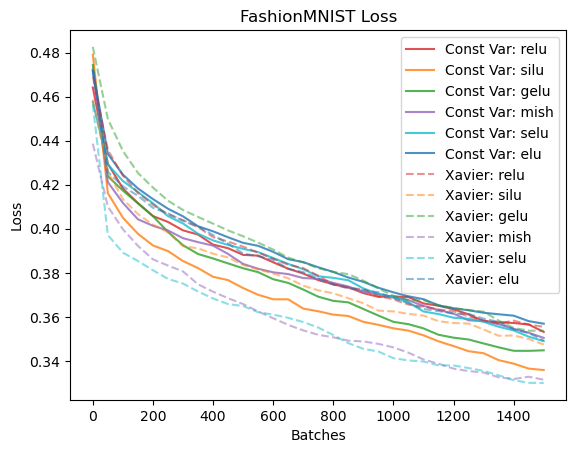

In [65]:
# Plot data and save figures
window_size = 70
for activation_function, loss in const_var_losses.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.8)
for activation_function, loss in xavier_losses.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.5)
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Batches")
plt.title("FashionMNIST Loss")

(0.8, 0.89)

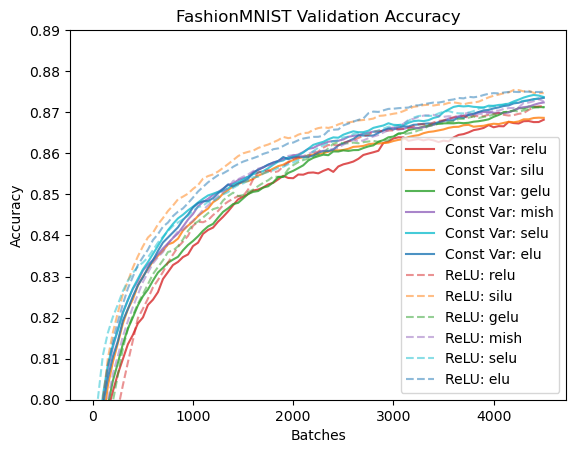

In [67]:
window_size = 10
for activation_function, loss in const_var_validation_acc.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.8)
for activation_function, loss in xavier_validation_acc.items():
    if activation_function != "sigmoid":
        plt.plot([(i*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), label="ReLU: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.5)
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.xlabel("Batches")
plt.title("FashionMNIST Validation Accuracy")
plt.ylim(0.8, 0.89)

In [49]:
# Merge the separate losses/accuracies into a single array to get mean and std

const_var_losses_merged = {}
for k, v in const_var_losses[1].items():
    const_var_losses_merged[k] =  np.median([const_var_losses[i][k] for i in range(len(const_var_losses))], axis=0)

xavier_losses_merged = {}
for k, v in xavier_losses[1].items():
    xavier_losses_merged[k] =  np.median([xavier_losses[i][k] for i in range(len(xavier_losses))], axis=0)

const_var_acc_merged = {}
for k, v in const_var_acc[1].items():
    const_var_acc_merged[k] =  np.median([xavier_acc[i][k] for i in range(len(xavier_acc))], axis=0)

xavier_acc_merged = {}
for k, v in const_var_acc[1].items():
    xavier_acc_merged[k] =  np.median([const_var_acc[i][k] for i in range(len(const_var_acc))], axis=0)


In [81]:
def window_data(values, moving_average_window_size=200):
    return np.convolve(values, np.ones(moving_average_window_size), 'valid') / moving_average_window_size

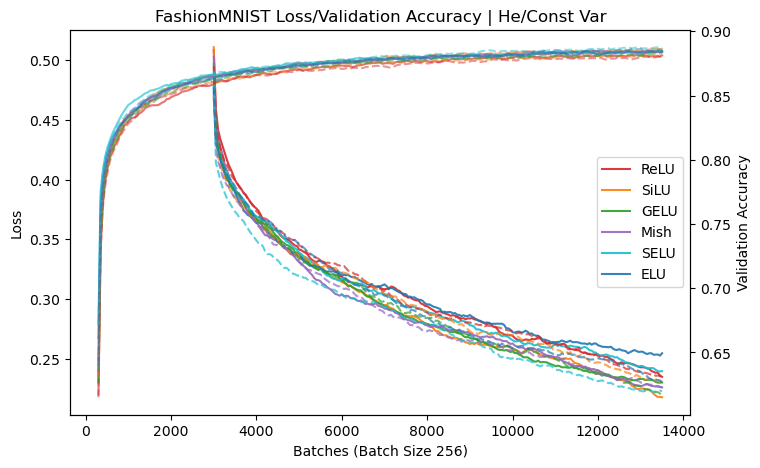

In [103]:
fig, ax = plt.subplots(figsize=(8, 5))

window_size = 60
batches = 50
activation_function_dict_names = {
    "relu": "ReLU",
    "silu": "SiLU",
    "gelu": "GELU",
    "mish": "Mish",
    "selu": "SELU",
    "elu": "ELU",
}

for activation_function, loss in const_var_losses_merged.items():
    if activation_function != "sigmoid":
        plt.plot([((i+ window_size)*batches ) for i in range(len(loss)-window_size+1)], window_data(loss, window_size), label= str(activation_function_dict_names[activation_function]), color=activation_color_dict[activation_function], linestyle='-', alpha=0.9)
for activation_function, loss in xavier_losses_merged.items():
    if activation_function != "sigmoid":
        plt.plot([((i+ window_size)*batches) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), color=activation_color_dict[activation_function], linestyle='--', alpha=0.7)

valid_alpha = 0.7
ax_valid = ax.twinx()

window_size = 6

for activation_function, loss in const_var_acc_merged.items():
    if activation_function != "sigmoid":
        ax_valid.plot([((i+ window_size)*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), color=activation_color_dict[activation_function], linestyle='-', alpha=0.9*valid_alpha)
for activation_function, loss in xavier_acc_merged.items():
    if activation_function != "sigmoid":
        ax_valid.plot([((i+ window_size)*50) for i in range(len(window_data(loss, window_size)))], window_data(loss, window_size), color=activation_color_dict[activation_function], linestyle='--', alpha=0.7*valid_alpha)

ax_valid.set_ylabel("Validation Accuracy")
ax.set_ylabel("Loss")
ax.set_xlabel("Batches (Batch Size 256)")
ax.legend(loc="center right")
plt.title("FashionMNIST Loss/Validation Accuracy | He/Const Var")
plt.savefig("./FashionMNIST_HeInit8.png")

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [1]:
import json
import matplotlib.pyplot as plt

const_var_losses = []
xavier_losses = []

xavier_acc = []
const_var_acc = []

for i in range(0, 5):
    prefix = "./HeConstVarFashionMNIST_test/" + str(i) + "/"
    # Load in data
    with open(prefix + "he_tests_losses.json", "r") as f:
        xavier_losses.append(json.load(f))

    with open(prefix + "const_var_tests_losses.json", "r") as f:
        const_var_losses.append(json.load(f))

    with open(prefix + "he_tests_validation_acc.json", "r") as f:
        xavier_acc.append(json.load(f))

    with open(prefix + "const_var_tests_validation_acc.json", "r") as f:
        const_var_acc.append(json.load(f))

activation_color_dict = {
    "relu": "tab:red",
    "silu": "tab:orange",
    "gelu": "tab:green",
    "mish": "tab:purple",
    "selu": "tab:cyan",
    "elu": "tab:blue",
}

activation_function_dict_names = {
    "relu": "ReLU",
    "silu": "SiLU",
    "gelu": "GELU",
    "mish": "Mish",
    "selu": "SELU",
    "elu": "ELU",
}


In [20]:
def get_mean(data):
    return np.mean(data, axis=0)

def get_std(data):
    return np.std(data, axis=0)

def window_data(data, moving_window_size=160):
    return np.convolve(data, np.ones(moving_window_size), 'valid') / moving_window_size

window_size = 100


In [17]:
accumulated_values = []

mean_loss_dict_xavier = {}
std_loss_dict_xavier = {}

mean_loss_dict_const_var = {}
std_loss_dict_const_var = {}

mean_acc_dict_xavier = {}
std_acc_dict_xavier = {}

mean_acc_dict_const_var = {}
std_acc_dict_const_var = {}


for activation_function in xavier_losses[0].keys():
    accumulated_values.clear()
    for loss_dict in xavier_losses:
        accumulated_values.append(loss_dict[activation_function])
    mean_loss_dict_xavier[activation_function] = get_mean(accumulated_values)
    std_loss_dict_xavier[activation_function] = get_std(accumulated_values)

    accumulated_values.clear()
    for loss_dict in const_var_losses:
        accumulated_values.append(loss_dict[activation_function])
    mean_loss_dict_const_var[activation_function] = get_mean(accumulated_values)
    std_loss_dict_const_var[activation_function] = get_std(accumulated_values)

    accumulated_values.clear()
    for acc_dict in xavier_acc:
        accumulated_values.append(acc_dict[activation_function])
    mean_acc_dict_xavier[activation_function] = get_mean(accumulated_values)
    std_acc_dict_xavier[activation_function] = get_std(accumulated_values)

    accumulated_values.clear()
    for acc_dict in const_var_acc:
        accumulated_values.append(acc_dict[activation_function])
    mean_acc_dict_const_var[activation_function] = get_mean(accumulated_values)
    std_acc_dict_const_var[activation_function] = get_std(accumulated_values)

In [23]:
mean_acc_dict_xavier.keys()

dict_keys(['relu', 'silu', 'gelu', 'mish', 'selu', 'elu'])

In [ ]:
activation_color_dict = {
    "relu": "tab:red",
    "silu": "tab:orange",
    "gelu": "tab:green",
    "mish": "tab:purple",
    "selu": "tab:cyan",
    "elu": "tab:blue",
}

activation_function_dict_names = {
    "relu": "ReLU",
    "silu": "SiLU",
    "gelu": "GELU",
    "mish": "Mish",
    "selu": "SELU",
    "elu": "ELU",
}

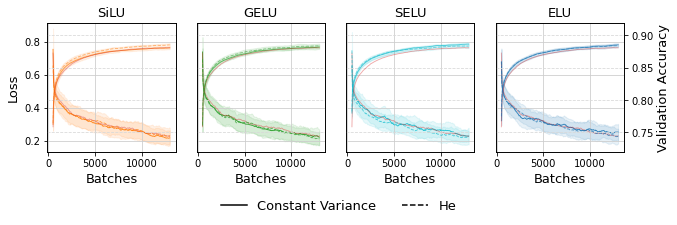

In [47]:
start = 1
stop = 5

include = ['silu', 'gelu', 'elu', 'selu',]

plt.rcParams.update({
    "text.usetex": False,
})

plt.rcParams.update({'font.size': 14})
font_size = 13

plt.rc('font', size=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('axes', titlesize=font_size)

plt.rc('ytick', labelsize=10)
plt.rc('xtick', labelsize=10)

plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)

fig, ax = plt.subplots(1, stop-start, figsize=(4.8*2, 0.96*1.5*2))
lw=0.9

tick_font_size = 8

window_size = 20
valid_window_size = 4
ax[0].set_ylabel("Loss")

std_alpha = 0.1

##########################################################
####################### LOSS #############################
##########################################################
cur_i = 0
for i, (activation_function, loss) in enumerate(mean_loss_dict_const_var.items()):
    if activation_function not in include:
        continue

    i = cur_i

    ax[i].grid(visible=True, which='both', color='0.8', linestyle='-')
    ax[i].set_title(activation_function_dict_names[activation_function])
    ax[i].set_xlabel("Batches")
    ax[i].sharey(ax[0])
    ax[i].set_xticks([0, 5_000, 10_000, 20_000, 30_000])

    if i != 0:
        ax[i].label_outer()
        ax[i].tick_params('y', width=0)

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(std_loss_dict_const_var[activation_function], window_size)

    ax[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict[activation_function], alpha=std_alpha)
    ax[i].plot(x_axis, means, label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.9, lw=lw)
    ax[i].plot(x_axis, window_data(mean_loss_dict_xavier["relu"], window_size), color=activation_color_dict["relu"], linestyle='-', alpha=0.4, lw=lw)
    cur_i += 1

############################ HE ##########################
cur_i = 0
for i, (activation_function, loss) in enumerate(mean_loss_dict_xavier.items()):
    if activation_function not in include:
        continue

    i = cur_i

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(std_loss_dict_xavier[activation_function], window_size)

    ax[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict[activation_function], alpha=std_alpha)
    ax[i].plot(x_axis, means, label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.7, lw=lw)

    cur_i += 1


##########################################################
##################### ACCURACY ###########################
##########################################################
valid_alpha = 0.8
ax_valid = [a.twinx() for a in ax]

cur_i = 0
#window_size = 4
for i, (activation_function, loss) in enumerate(mean_acc_dict_const_var.items()): #[start:stop]
    if activation_function not in include:
        continue
        #pass
    i = cur_i
    ax_valid[stop-start-1].set_ylabel("Validation Accuracy")
    ax_valid[i].sharey(ax_valid[0])
    ax_valid[i].set_yticks([0.75, 0.8, 0.85, 0.9])
    ax_valid[i].set_ylim([0.72, 0.92])
    ax_valid[i].grid(visible=True, which='both', color='0.85', linestyle='--')

    if i + start != stop-1:
        ax_valid[i].label_outer()
        ax_valid[i].tick_params('y', width=0)

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(std_acc_dict_const_var[activation_function], window_size)

    ax_valid[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict[activation_function], alpha=std_alpha)
    ax_valid[i].plot(x_axis, means, label="Const Var: " + str(activation_function), color=activation_color_dict[activation_function], linestyle='-', alpha=0.9*valid_alpha, lw=lw)
    ax_valid[i].plot(x_axis, window_data(mean_acc_dict_xavier["relu"], window_size), color=activation_color_dict["relu"], linestyle='-', alpha=0.4, lw=lw)
    cur_i += 1

############################ HE ##########################
cur_i = 0
for i, (activation_function, loss) in enumerate(mean_acc_dict_xavier.items()):
    if activation_function not in include:
        continue

    i = cur_i

    x_axis = [(window_size/2)*50 + i*50 for i in range(len(window_data(loss, window_size)))]
    means = window_data(loss, window_size)
    stds = window_data(std_acc_dict_xavier[activation_function], window_size)

    ax_valid[i].fill_between(x_axis , means-stds, means+stds, color=activation_color_dict[activation_function], alpha=std_alpha)
    ax_valid[i].plot(x_axis, window_data(loss, window_size), label="Xavier: " +str(activation_function), color=activation_color_dict[activation_function], linestyle='--', alpha=0.7*valid_alpha, lw=lw)
    cur_i += 1

labels = ["Constant Variance", "He"]

red_patch = mpatches.Patch(color='red', label='The red data')
line1 = mlines.Line2D([], [], color='black', label='Constant Variance')
line2 = mlines.Line2D([], [], color='black', label='He', linestyle="--")

#left, bottom, width, height
fig.legend(handles=[line1, line2], loc="center",  bbox_to_anchor=(0.5, -0.03, 0, 0),  ncol=2, frameon=False)
fig.tight_layout()
fig.savefig("./CIFAR10_FashionMNIST_2_hires.png", bbox_inches='tight', dpi=800)
